<a href="https://colab.research.google.com/github/khushboo0824/cognitive-assessment-/blob/main/Tranfer%20Learning/vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khushboochauhan08","key":"1f0a8cdbb234c5e6b881934f26aac3f1"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy


Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 99% 71.0M/71.5M [00:00<00:00, 88.5MB/s]
100% 71.5M/71.5M [00:00<00:00, 78.0MB/s]


In [4]:
import zipfile

dataset_path = "/content/best-alzheimer-mri-dataset-99-accuracy.zip"
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall("/content/MRI_Dataset")

In [5]:
# Essential Libraries
import os
import glob
import copy
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress Warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Sequential, Model, applications
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Flatten, BatchNormalization, Activation, MaxPool2D, Conv2D,
    GlobalAveragePooling2D, RandomRotation, RandomZoom
)
from tensorflow.keras.metrics import Precision, AUC, Recall
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input as vgg19_preprocess
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet50_preprocess
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_v3_preprocess
# Image Processing
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Machine Learning Utilities
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/MRI_Dataset/Combined Dataset/train'  # Replace with your actual path
test_dir = '/content/MRI_Dataset/Combined Dataset/test'
# Define ImageDataGenerator with validation split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training data (80%)
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Adjust based on your model input
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation data (20%)
val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Test Data (loaded separately)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)


Found 8192 images belonging to 4 classes.
Found 2048 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [7]:
class_names=list(train_generator.class_indices.keys())
print(class_names)

['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


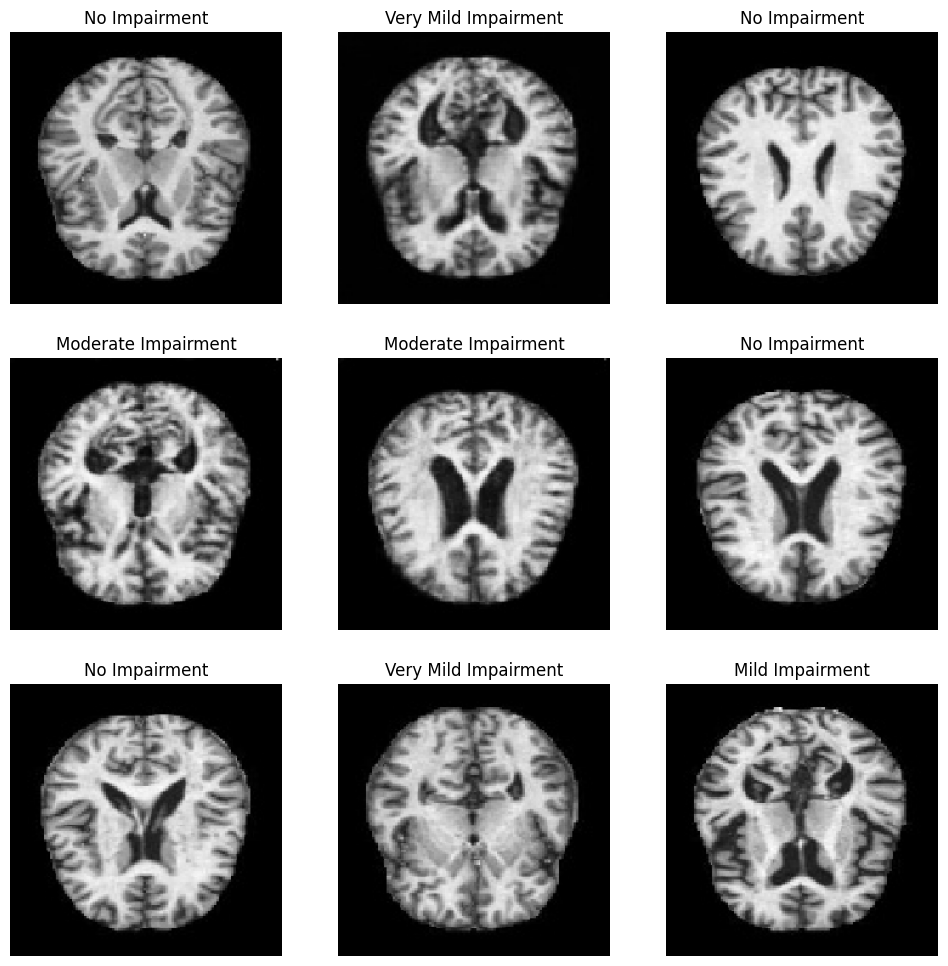

In [ ]:
#Visualizing images of different classes
plt.figure(figsize=(12,12))

for images,labels in train_generator:
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i])
        print(images[i].shape)
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    break

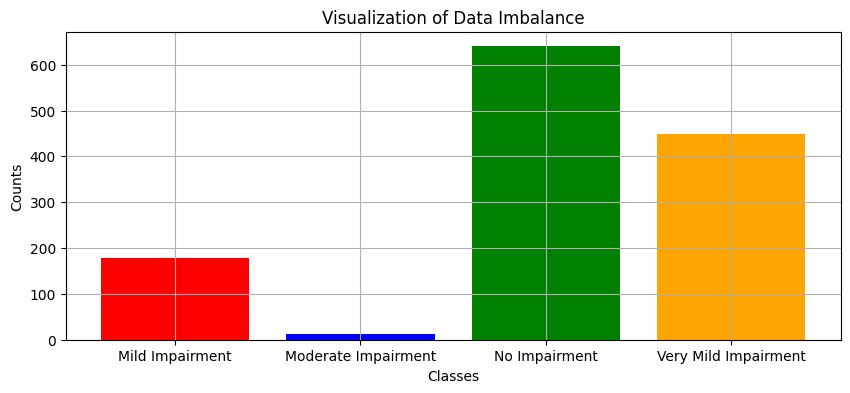

In [23]:
input_folder='/content/MRI_Dataset/Combined Dataset/test'

class_count=dict()

for i in class_names:
    class_count[i]=len(os.listdir(input_folder+'/'+i))

plt.figure(figsize=(10,4))
colors = ['red', 'blue', 'green', 'orange']
plt.bar(class_count.keys(),class_count.values(),color=colors)

plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Visualization of Data Imbalance')
plt.grid(True)
plt.show()

In [ ]:
total_samples=sum(class_count.values())

for i in range(4):
    class_weight = round(total_samples / (4 * list(class_count.values())[i]), 2)
    print(f'Weight for class \"{class_names[i]}\" : {class_weight}')

Weight for class "Mild Impairment" : 1.0
Weight for class "Moderate Impairment" : 1.0
Weight for class "No Impairment" : 1.0
Weight for class "Very Mild Impairment" : 1.0


Dara augmentation

In [8]:
def data_augmentar():
    data_augmentation = Sequential()
    data_augmentation.add(RandomRotation(factor=(-0.15, 0.15)))
    data_augmentation.add(RandomZoom((-0.3, -0.1)))
    return data_augmentation


In [9]:
data_augmentation = data_augmentar()
assert(data_augmentation.layers[0].name.startswith('random_rotation'))
assert(data_augmentation.layers[0].factor == (-0.15, 0.15))
assert(data_augmentation.layers[1].name.startswith('random_zoom'))
assert(data_augmentation.layers[1].height_factor == (-0.3, -0.1))

In [10]:
filepath = './Vgg_best_weights.keras'
earlystopping=EarlyStopping(monitor='val_accuracy',
                           mode='max',
                           patience=15,
                           verbose=1)

checkpoint=ModelCheckpoint(filepath,monitor = 'val_accuracy',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)

callback_list=[earlystopping,checkpoint]

VGG-16


In [11]:
input_shape = (224, 224, 3)

# Create an instance of the VGG16 model
vgg16 = VGG16(include_top=False, input_shape=input_shape, weights='imagenet')

# Freeze the layers of the VGG16 model
for layer in vgg16.layers:
    layer.trainable = False

# Define new layers
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')

# Create final model
model = tf.keras.Sequential([
    vgg16,
    global_average_layer,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    prediction_layer
])

# Compile Model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=3,           # Stop if no improvement after 3 epochs
    restore_best_weights=True  # Restore the best model weights
)

# Train the model with EarlyStopping
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    verbose=1,
    callbacks=[early_stop]  # Add the callback here
)


Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 5980s 23s/step - accuracy: 0.7009 - auc: 0.9097 - loss: 0.6697 - precision: 0.7864 - recall: 0.6167 - val_accuracy: 0.6782 - val_auc: 0.9109 - val_loss: 0.7683 - val_precision: 0.8561 - val_recall: 0.5083
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 6009s 23s/step - accuracy: 0.8753 - auc: 0.9832 - loss: 0.3067 - precision: 0.8943 - recall: 0.8586 - val_accuracy: 0.7388 - val_auc: 0.9465 - val_loss: 0.5390 - val_precision: 0.7760 - val_recall: 0.7070
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 6009s 23s/step - accuracy: 0.9216 - auc: 0.9914 - loss: 0.2132 - precision: 0.9328 - recall: 0.9126 - val_accuracy: 0.7583 - val_auc: 0.9518 - val_loss: 0.6072 - val_precision: 0.7697 - val_recall: 0.7490
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 5929s 23s/step - accuracy: 0.9504 - auc: 0.9961 - loss: 0.1335 - precision: 0.9534 - recall: 0.9477 - val_accuracy: 0.7886 - val_auc: 0.9445 - val_loss: 0.7654 - val_precision: 0.7945 - val_recall: 0.7817
Epoch 5/20
256/256 ━

In [13]:
#Train Loss,Accuracy,AUC,Precision,Recall
result = model.evaluate(train_generator)
train_loss = result[0]
train_accuracy = result[1]
train_AUC = result[2]
train_pre = result[3]
train_rec = result[4]
print(f'Train Loss = {train_loss}')
print(f'Train Accuracy = {train_accuracy}')
print(f'Train AUC = {train_AUC}')
print(f'Train Precision = {train_pre}')
print(f'Train Recall = {train_rec}')

256/256 ━━━━━━━━━━━━━━━━━━━━ 4821s 19s/step - accuracy: 0.9129 - auc: 0.9912 - loss: 0.2735 - precision: 0.9420 - recall: 0.8729
Train Loss = 0.27228429913520813
Train Accuracy = 0.9124755859375
Train AUC = 0.9912843704223633
Train Precision = 0.9411764740943909
Train Recall = 0.873046875


In [14]:

#Test Loss,Accuracy,AUC,Precision,Recall
result = model.evaluate(test_generator)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]
print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 749s 19s/step - accuracy: 0.7609 - auc: 0.9356 - loss: 0.6015 - precision: 0.8190 - recall: 0.6817
Test Loss = 0.6119995713233948
Test Accuracy = 0.7271305918693542
Test AUC = 0.9321387410163879
Test Precision = 0.7691605687141418
Test Recall = 0.6591086983680725


PLOTS

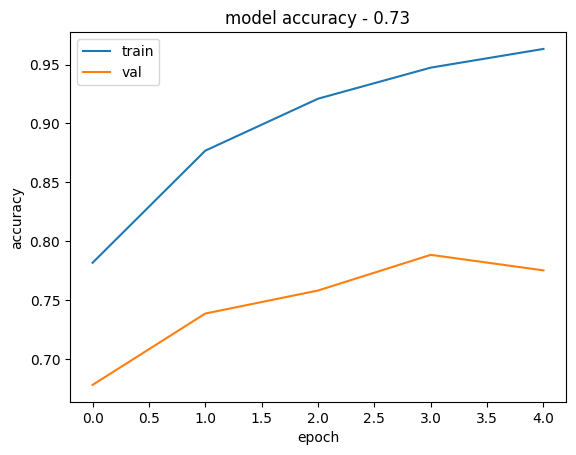

In [15]:
#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy - ' + str(format(result[1], "0.2f")))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

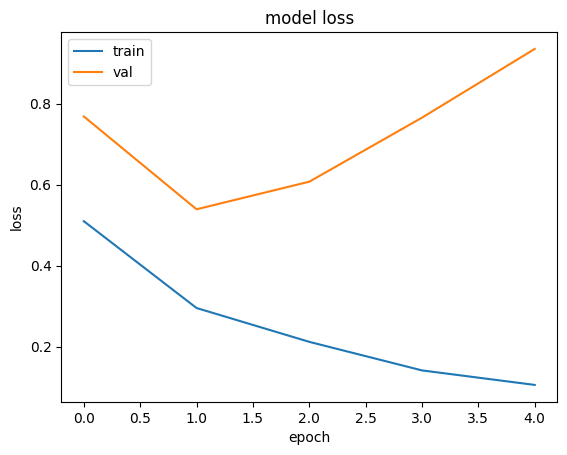

In [16]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

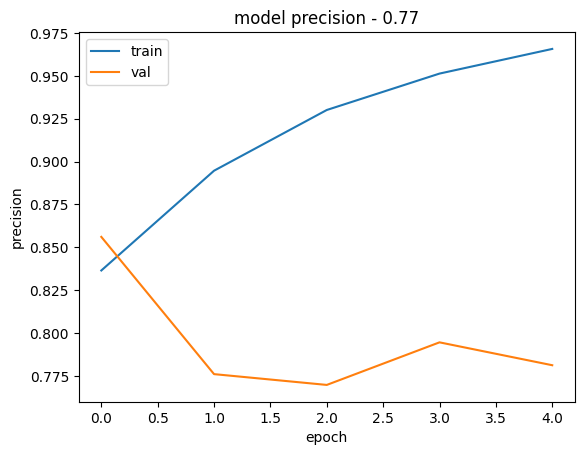

In [17]:
#Precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision - ' + str(format(result[3], "0.2f")))
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
test_label=test_generator.classes

In [19]:
Y_pred=model.predict(test_generator)

40/40 ━━━━━━━━━━━━━━━━━━━━ 750s 19s/step


In [20]:
y_pred=[]
[y_pred.append(np.argmax(l)) for l in Y_pred ]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

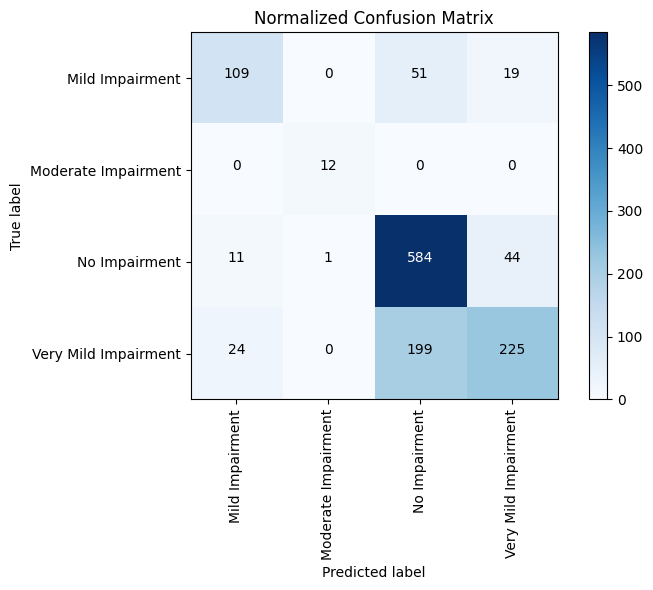

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized Confusion Matrix"
    else:
        title = "Confusion Matrix"

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
#     '.2f' if normalize else
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(test_label, y_pred)

class_names

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, class_names, normalize=True)
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
# Compute the classification report
report = classification_report(test_label, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.61      0.67       179
           1       0.92      1.00      0.96        12
           2       0.70      0.91      0.79       640
           3       0.78      0.50      0.61       448

    accuracy                           0.73      1279
   macro avg       0.79      0.76      0.76      1279
weighted avg       0.74      0.73      0.71      1279



VGG19

In [27]:
input_shape = (224, 224, 3)

# Create an instance of the VGG16 model
vgg16 = VGG16(include_top=False, input_shape=input_shape, weights='imagenet')

# Freeze the layers of the VGG16 model
for layer in vgg16.layers:
    layer.trainable = False

# Define new layers
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')

# Create final model
model12 = tf.keras.Sequential([
    vgg16,
    global_average_layer,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    prediction_layer
])

# Compile Model
model12.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=3,           # Stop if no improvement after 3 epochs
    restore_best_weights=True  # Restore the best model weights
)

# Train the model with EarlyStopping
history2 = model12.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    verbose=1,
    callbacks=[early_stop]  # Add the callback here
)


Epoch 1/20
 82/256 ━━━━━━━━━━━━━━━━━━━━ 54:36 19s/step - accuracy: 0.6476 - auc_3: 0.8822 - loss: 0.7949 - precision_3: 0.7364 - recall_3: 0.5406